# Colab runtime

The recommended runtime to use for fitting the gpSLDS is a NVIDIA A100 GPU. On Colab, you can select this runtime by clicking Runtime -> Change runtime type -> A100 GPU.

If an A100 is not available, other GPUs may be selected using the steps above. In that case you may need to change the batch size to fit the model using stochastic vEM in order to avoid out-of-memory errors.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general imports
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import pickle
import matplotlib.pyplot as plt

In [4]:
# import functions from gpslds codebase
import sys

sys.path.append("data")
from generate_synthetic_data import generate_synthetic_dynamics

sys.path.append("gpslds")
from kernels import Linear, SSL
from transition import SparseGP
from likelihoods import PoissonProcess
from initialization import initialize_zs
from quadrature import GaussHermiteQuadrature
from em import fit_variational_em
from utils import get_transformation_for_latents, get_posterior_f_mean, get_posterior_f_var, get_most_likely_state, get_learned_partition

# Plotting helper functions

Helper functions for plotting the synthetic data.

In [ ]:
def plot_dynamics(dynamics_fn, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x, y = jnp.meshgrid(
        jnp.linspace(*xlim, n_xpts),
        jnp.linspace(*ylim, n_ypts)
    )
    input_locs = jnp.column_stack([x.ravel(), y.ravel()])

    fs = vmap(dynamics_fn)(input_locs)
    ax.quiver(input_locs[:,0], input_locs[:,1], fs[:,0], fs[:,1], angles='xy')
    ax.set_title("true dynamics", fontsize=fontsize)
    ax.set_xlabel(r"$x_1$", fontsize=fontsize)
    ax.set_ylabel(r"$x_2$", fontsize=fontsize)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax

def plot_dynamics_and_latents(dynamics_fn, latents, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12, alpha=0.5):
    assert latents.shape[-1] == 2
    ax = plot_dynamics(dynamics_fn, xlim=xlim, ylim=ylim, n_xpts=n_xpts, n_ypts=n_ypts, ax=ax, figsize=figsize, fontsize=fontsize)
    for latent in latents:
        ax.plot(latent[:,0], latent[:,1], alpha=alpha)
    ax.set_title("true dynamics & latents")
    return ax

def plot_latents_over_time(t_max, latents_mean, latents_cov=None, ax=None, figsize=(4, 3), fontsize=12, color='red', alpha=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    t_grid = jnp.linspace(0, t_max, latents_mean.shape[0])
    latent_dim = latents_mean.shape[-1]

    for i in range(latent_dim):
        ax.plot(t_grid, latents_mean[:,i], color=color)

    if latents_cov is not None:
        for i in range(latent_dim):
            ax.fill_between(t_grid, latents_mean[:,i]+2*jnp.sqrt(latents_cov[:,i,i]),
                    latents_mean[:,i]-2*jnp.sqrt(latents_cov[:,i,i]), facecolor=color, alpha=alpha)

    ax.set_xlabel("time (s)", fontsize=fontsize)
    ax.set_ylabel(r"$x_1(t), x_2(t)$", fontsize=fontsize)
    return ax

# Load in dataset and pLDS emissions

In [5]:
# load in data and initial emissions parameters
data_path = "data/synthetic_data_v2.pkl"
with open(data_path, 'rb') as f:
    dataset = pickle.load(f)
dt, all_xs, all_spikes, C, d = dataset
all_xs = jnp.array(all_xs)
all_spikes = jnp.array(all_spikes)
C = jnp.array(C)
d = jnp.array(d)

emissions_path = "data/synthetic_plds_emissions.pkl"
with open(emissions_path, 'rb') as f:
    elbos, q, C_plds, d_plds = pickle.load(f)
C_plds = jnp.array(C_plds)
d_plds = jnp.array(d_plds)

/home/users/amberhu/ssm/ssm/observations.py:824: SyntaxWarning: invalid escape sequence '\s'
  """
/home/users/amberhu/ssm/ssm/transitions.py:370: SyntaxWarning: invalid escape sequence '\p'
  """
/home/users/amberhu/ssm/ssm/transitions.py:505: SyntaxWarning: invalid escape sequence '\s'
  """
/home/users/amberhu/ssm/ssm/emissions.py:597: SyntaxWarning: invalid escape sequence '\p'
  """
/home/users/amberhu/ssm/ssm/emissions.py:620: SyntaxWarning: invalid escape sequence '\p'
  """
/home/users/amberhu/ssm/ssm/variational.py:219: SyntaxWarning: invalid escape sequence '\s'
  """
/home/users/amberhu/ssm/ssm/variational.py:452: SyntaxWarning: invalid escape sequence '\i'
  """


In [6]:
# select subset of data for fitting
n_trials = 30
inds_to_select = jnp.concatenate((jnp.arange(int(n_trials/2)), jnp.arange(int(len(all_xs)/2), int(len(all_xs)/2)+int(n_trials/2))))
xs = all_xs[inds_to_select]
spikes = all_spikes[inds_to_select]

In [7]:
# get dimensions and constants
latent_dim = xs.shape[-1]
_, n_timesteps, output_dim = spikes.shape
t_max = n_timesteps * dt

# Plot true dynamics, latents, and observations

<Axes: title={'center': 'true dynamics'}, xlabel='$x_1$', ylabel='$x_2$'>

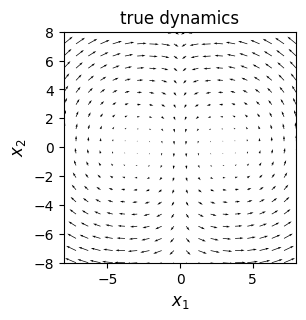

In [8]:
# visualize true dynamics flow field
plot_dynamics(generate_synthetic_dynamics, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: title={'center': 'true dynamics & latents'}, xlabel='$x_1$', ylabel='$x_2$'>

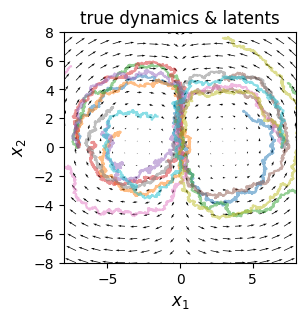

In [9]:
# plot true latent states on top of true dynamics
plot_dynamics_and_latents(generate_synthetic_dynamics, xs, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

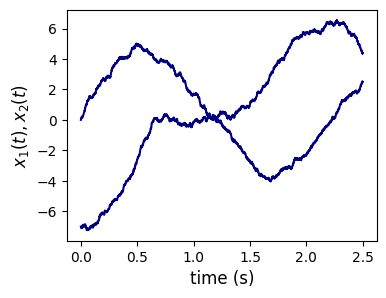

In [10]:
# plot observations for one trial
trial_idx = 0
plot_latents_over_time(t_max, xs[trial_idx], color='navy')

# Initialize the model

In [8]:
# initialize quadrature object and kernel
num_bases = 3
basis_set = lambda x: jnp.array([1., x[0], x[1]])
gh_quad = GaussHermiteQuadrature(latent_dim, n_quad=5)
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4
zs = initialize_zs(latent_dim, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)

# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = PoissonProcess(spikes, t_mask, dt, gh_quad, link='softplus')

In [9]:
# generate random seeds
key = jr.PRNGKey(1)
key_W, key_fp = jr.split(key, 2)

# intiialize number of linear states and kernel hyperparameters
num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, latent_dim), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

# initialize initial conditions for latents from Poisson LDS
x0_init_params = jnp.stack([q.mean_continuous_states[i][0] for i in inds_to_select])

# initialize output parameters from Poisson LDS
output_params_init = {'C': C_plds, 'd': d_plds}

# Debugging

NOTE: so far, likelihood terms still have a vmap over time. Should fix this to be consistent.

In [10]:
from initialization import initialize_vem
mean_init, var_init = 0., dt * 10
inputs = jnp.zeros((n_trials, n_timesteps, 1))
K = 2
S0, V0, As, bs, ms, Ss, q_u_mu, q_u_sigma, B = initialize_vem(n_trials, n_timesteps, K, M, inputs.shape[-1], mean_init, var_init)

In [11]:
from em import compute_elbo_all_trials
elbo_fn = lambda ms, Ss: compute_elbo_all_trials(dt, fn, likelihood, trial_mask, ms, Ss, As, bs, inputs, B, output_params_init, kernel, kernel_params_init, q_u_mu, q_u_sigma)

In [12]:
# this works
elbo_fn(ms, Ss)

Array(-75573614.09483895, dtype=float64)

In [13]:
# gradient of elbo function (in e-step). this works with opt 1+2
from em import compute_elbo_per_trial
elbo_fn = lambda ms, Ss, As, bs: compute_elbo_per_trial(dt, fn, likelihood, spikes[0], t_mask[0], trial_mask[0], ms, Ss, As, bs, inputs[0], B, q_u_mu, q_u_sigma, output_params_init, kernel, kernel_params_init)
# val = elbo_fn(ms[0], Ss[0], As[0], bs[0])
dLdms, dLdSs = jax.grad(elbo_fn, argnums=(0, 1))(ms[0], Ss[0], As[0], bs[0]) 

In [14]:
# this works with opt 1+2
from em import e_step

ms_batch, Ss_batch, lmbdas, Psis, As_batch, bs_batch = e_step(dt, 
                                                              fn, 
                                                              likelihood, 
                                                              jnp.arange(n_trials), 
                                                              trial_mask, 
                                                              As, 
                                                              bs, 
                                                              x0_init_params, 
                                                              S0, 
                                                              inputs, 
                                                              B, 
                                                              q_u_mu, 
                                                              q_u_sigma, 
                                                              output_params_init, 
                                                              kernel, 
                                                              kernel_params_init, 
                                                              n_iters_e=1)

In [16]:
# this works with opt 1+2
from em import compute_elbo
loss_fn_output_params = lambda output_params: -compute_elbo(dt, fn, likelihood, jnp.arange(n_trials), trial_mask, ms, Ss, As, bs, inputs, B, output_params, kernel, kernel_params_init)
output_params = likelihood.update_output_params(ms, Ss, output_params_init, loss_fn_output_params, n_iters_m=2)

In [36]:
# it breaks here :(
from em import sgd
loss_fn_kernel_params = lambda kernel_params: -compute_elbo(dt, fn, likelihood, jnp.arange(n_trials), trial_mask, ms, Ss, As, bs, inputs, B, output_params_init, kernel, kernel_params)
kernel_params, _ = sgd(loss_fn_kernel_params, kernel_params_init, n_iters_m=2, learning_rate=0.02)

2024-11-13 21:12:30.409937: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 4.11GiB (4409748638 bytes) by rematerialization; only reduced to 6.59GiB (7079053408 bytes), down from 6.59GiB (7079060472 bytes) originally
2024-11-13 21:12:45.851521: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.77GiB (rounded to 7266917632)requested by op 
2024-11-13 21:12:45.851880: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *****_______________________________________________________________________________________________
E1113 21:12:45.851931   40050 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7266917480 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7266917480 bytes.

In [63]:
# zooming into the kernel params update step, it definitely breaks here.
from utils import make_gram
from em import update_q_u
def helper1(kernel_params):
    Kzz = make_gram(kernel.K, kernel_params, fn.zs, fn.zs, jitter=fn.jitter)
    q_u_mu, q_u_sigma = update_q_u(dt, fn, trial_mask, ms, Ss, As, bs, inputs, B, kernel, kernel_params, Kzz) 
    # prior_term = fn.prior_term(q_u_mu, q_u_sigma, kernel_params)
    return q_u_mu.sum()

val1 = helper1(kernel_params_init)
grad1 = jax.grad(helper1)(kernel_params_init)
# jax.make_jaxpr(jax.grad(helper1))(kernel_params_init)

2024-11-13 21:24:06.644877: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 1.26GiB (1356116548 bytes) by rematerialization; only reduced to 3.88GiB (4165350520 bytes), down from 3.90GiB (4186725936 bytes) originally
2024-11-13 21:24:17.904639: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 43.06MiB (rounded to 45151744)requested by op 
2024-11-13 21:24:17.905095: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ****************************************************************************************************
E1113 21:24:17.905138   40050 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 45151592 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 45151592 bytes.

In [88]:
from jax import lax
# split q(u) update into corresponding parts. this works with gradient ch
# def _q_u_sigma_int(dt, fn, trial_mask, ms, Ss, kernel, kernel_params):
#     E_KzxKxz_on_grid = vmap(partial(kernel.E_KzxKxz, fn.zs, kernel_params=kernel_params))(ms, Ss) # (T, M, M)
#     int_E_KzxKxz = dt * (E_KzxKxz_on_grid * trial_mask[...,None,None]).sum(0)
#     return int_E_KzxKxz.sum()
n_trials, T, K = ms.shape
I = inputs.shape[-1]
chunk_size = 500 # for the time being. need to pass as argument. note: cannot set to sqrt(T) because this is input-shape dependent
ms_chunks = ms.reshape(-1, chunk_size, K)
Ss_chunks = Ss.reshape(n_trials, -1, chunk_size, K, K)
As_chunks = As.reshape(n_trials, -1, chunk_size, K, K)
bs_chunks = bs.reshape(n_trials, -1, chunk_size, K)
inputs_chunks = inputs.reshape(n_trials, -1, chunk_size, I)
mask_chunks = trial_mask.reshape(n_trials, -1, chunk_size)

def _q_u_sigma_int(dt, fn, trial_mask, ms, Ss, kernel, kernel_params):
    def _chunk_vmap(ms_c, Ss_c, trial_mask_c):
        E_KzxKxz_on_grid = vmap(partial(kernel.E_KzxKxz, fn.zs, kernel_params=kernel_params))(ms_c, Ss_c)
        int_E_KzxKxz = dt * (E_KzxKxz_on_grid * trial_mask_c[...,None,None]).sum(0)
        return int_E_KzxKxz
        
    def _outer_scan(ms_chunks, Ss_chunks, mask_chunks):
        def _step(carry, arg):
            int_term_c = _chunk_vmap(*arg)
            return carry + int_term_c, None
        int_term, _ = lax.scan(_step, 0., (ms_chunks, Ss_chunks, mask_chunks)) 
        return int_term

    int_term = _outer_scan(ms_chunks, Ss_chunks, mask_chunks)
    return int_term

val = _q_u_sigma_int(dt, fn, trial_mask[0], ms[0], Ss[0], kernel, kernel_params_init)
# grad = jax.grad(lambda kernel_params: _q_u_sigma_int(dt, fn, trial_mask[0], ms[0], Ss[0], kernel, kernel_params))(kernel_params_init)

ValueError: Incompatible shapes for matmul arguments: (500, 2, 2) and (25, 2, 1)

In [17]:
# this works with opt 1+2
from em import kl_over_time
from functools import partial
from utils import make_gram

def helper2(kernel_params):
    Kzz = make_gram(kernel.K, kernel_params, fn.zs, fn.zs, jitter=fn.jitter)
    Kzz_inv = jnp.linalg.solve(Kzz, jnp.eye(len(fn.zs)))
    kl_term = vmap(partial(kl_over_time, dt, fn, B=B, q_u_mu=q_u_mu, q_u_sigma=q_u_sigma, kernel=kernel, kernel_params=kernel_params, Kzz_inv=Kzz_inv))(trial_mask, ms, Ss, As, bs, inputs).sum()
    # kl_term = partial(kl_over_time, dt, fn, B=B, q_u_mu=q_u_mu, q_u_sigma=q_u_sigma, kernel=kernel, kernel_params=kernel_params, Kzz_inv=Kzz_inv)(trial_mask[0], ms[0], Ss[0], As[0], bs[0], inputs[0])
    return kl_term

grad = jax.grad(helper2)(kernel_params_init)

In [18]:
grad

{'W': Array([[ 0.21972579],
        [ 2.99256271],
        [-0.68285481]], dtype=float64),
 'linear_params': [{'fixed_point': Array([-8.69501875e-07,  1.80920458e-04], dtype=float64)},
  {'fixed_point': Array([-8.78704630e-06, -1.30722914e-04], dtype=float64)}],
 'log_tau': Array(0.54966816, dtype=float64, weak_type=True)}

# Fit model

In [23]:
key = jr.PRNGKey(0) # for minibatching; doesn't matter here, since we are using batch_size=n_trials

# set number of total vEM iters
n_iters = 5

# set a learning rate schedule
decay, forgetting_rate = 50, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate)

# fit model
result = fit_variational_em(key,
                            latent_dim,
                            dt,
                            fn,
                            likelihood,
                            trial_mask,
                            output_params_init,
                            kernel,
                            kernel_params_init,
                            inputs=None,
                            m0=x0_init_params,
                            mu0=x0_init_params,
                            n_iters=n_iters,
                            n_iters_e=15,
                            n_iters_m=150,
                            learning_rates=learning_rates,
                            batch_size=n_trials)

# collect results
ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

2024-11-11 18:19:20.162440: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 3.96GiB (4255843280 bytes) by rematerialization; only reduced to 6.15GiB (6607658716 bytes), down from 6.15GiB (6607658716 bytes) originally
2024-11-11 18:19:32.330344: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.73GiB (rounded to 8298484992)requested by op 
2024-11-11 18:19:32.330644: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] **********__________________________________________________________________________________________
E1111 18:19:32.330698   26057 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8298484872 bytes.
/home/users/amberhu/gpslds/gpslds/em.py:263: SyntaxWarning: invalid escape sequence '\i'
  """Computes \int_0^T u(t) u(t)^T dt."""
/home/users/amberhu/gpslds/gpslds/em.py:269:

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8298484872 bytes.

# Plot results

In [15]:
# compute necessary rotation matrices
P = get_transformation_for_latents(C, output_params['C'])

# rotate inferred latents
ms_rot = (P @ ms[...,None]).squeeze(-1)
Ss_rot = P @ Ss @ P.T

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

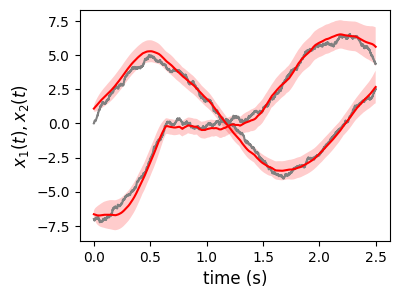

In [16]:
# plot true vs inferred latent states
trial_idx = 0
ax = plot_latents_over_time(t_max, xs[trial_idx], color='gray')
plot_latents_over_time(t_max, ms_rot[trial_idx], Ss_rot[trial_idx], color='red', ax=ax)

In [17]:
# visualize learned dynamics
# generate grid in true generative space
xlim = 8
n_grid = 15
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid),
    jnp.linspace(-xlim, xlim, n_grid)
)
Xs_rot = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)

# rotate grid to gpslds inferred space
Xs = jnp.linalg.solve(P, Xs_rot.T).T
Xs_grid = Xs.reshape(n_grid, n_grid, -1)

# generate mean of learned dynamics in gpslds space, then rotate back to true space
f_mean = get_posterior_f_mean(kernel.K, kernel_params, Xs, zs, q_u_mu)
f_mean_rot = (P @ f_mean[...,None]).squeeze(-1)

# compute posterior uncertainty
f_var = get_posterior_f_var(kernel.K, kernel_params, Xs, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

Text(0, 0.5, '$x_2$')

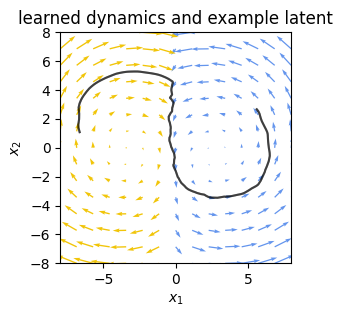

In [18]:
# plot learned dynamics colored by most likely state
trial_idx = 0

fig, ax = plt.subplots(figsize=(3, 3))
most_likely_state = get_most_likely_state(kernel.construct_partition, kernel_params, Xs)
colors = ["cornflowerblue", "#F1C509"]

for i in range(num_states):
    state_inds = (most_likely_state == i).astype(bool)
    ax.quiver(Xs_rot[state_inds,0], Xs_rot[state_inds,1], f_mean_rot[state_inds,0], f_mean_rot[state_inds,1], color=colors[i])
    ax.plot(ms_rot[trial_idx,:,0], ms_rot[trial_idx,:,1], 'k', alpha=0.5)
ax.set_aspect(1.)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title("learned dynamics and example latent")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [19]:
# compute posterior variance on a finer grid
# generate grid in true generative space
xlim = 8
n_grid_fine = 40
X1_fine, X2_fine = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid_fine),
    jnp.linspace(-xlim, xlim, n_grid_fine)
)
Xs_rot_fine = jnp.column_stack([X1_fine.ravel(), X2_fine.ravel()]) # (N**2, 2)
Xs_rot_grid_fine = Xs_rot_fine.reshape(n_grid_fine, n_grid_fine, -1)

# rotate to gpslds inferred space
Xs_fine = jnp.linalg.solve(P, Xs_rot_fine.T).T
Xs_grid_fine = Xs_fine.reshape(n_grid_fine, n_grid_fine, -1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs_fine, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

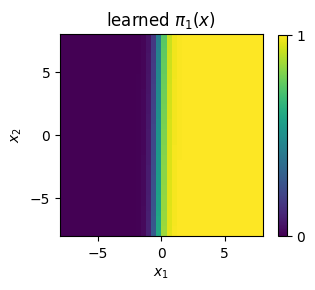

In [20]:
# plot learned partition function
learned_partition = get_learned_partition(kernel.construct_partition, kernel_params, Xs_fine)
learned_partition_grid = learned_partition.reshape(n_grid_fine, n_grid_fine, -1)

fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(learned_partition_grid[:,:,0], origin='lower', extent=[-xlim, xlim, -xlim, xlim])
ax.set_aspect(1.)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_title(r"learned $\pi_1(x)$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1])

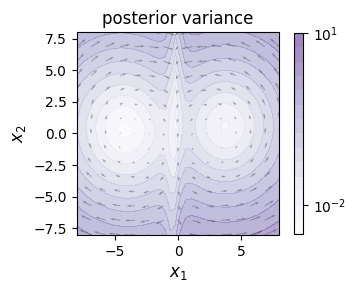

In [21]:
# plot learned dynamics with posterior uncertainty
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(3, 3))

levels = 10**(jnp.linspace(-2.5, 1, 15))
contour = ax.contourf(X1_fine, X2_fine, f_det_rot.reshape(n_grid_fine, n_grid_fine), levels=levels, alpha=0.5, locator=ticker.LogLocator(), cmap='Purples')
ax.quiver(Xs_rot[:,0], Xs_rot[:,1], f_mean_rot[:,0], f_mean_rot[:,1], color='black', alpha=0.3)

ax.set_aspect(1)
ax.set_title("posterior variance", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.locator = ticker.LogLocator(10)
cbar.set_ticks([1e-2, 1e1])